In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import matplotlib.colors as colors
import scipy as sp
import numpy as np
import emcee
import testkit
import corner
import pickle as pickle
from IPython.display import display
%matplotlib inline
import forwardmodel
import ciamod
import TPmod
import cloud
import band
import brewtools
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian1DKernel
from scipy.io import readsav
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
# from bensconv import spex_non_uniform
# from bensconv import conv_uniform_R
# from bensconv import conv_uniform_FWHM

## First step is to load the results file and the run arguments. 
We open the files and select the last couple of thousand iterations of the chain, and flatted this into a simple array of state vectors called "samples"

In [3]:
# path = "/Users/doglover612/Documents/BDNYC/"
runname = "G570D_Final/G570D_FullRetrieval_108"
# OK finish? 1 for yes, 0 for no.
fin = 1
flatendchain, flatendprobs,ndim = brewtools.get_endchain(runname,fin)
theta_max_end = flatendchain[np.argmax(flatendprobs)]
max_end_like = np.amax(flatendprobs)
samples = flatendchain

# argfile =runname+"_runargs.pic"

runargs = brewtools.pickle_load("G570D_Final/G570D_FullRetrieval_108_runargs.pic")
# If you're opening on a Linux box, use the code below
#with open(argfile, 'rb') as input:
#    runargs = pickle.load(input) 



maximum likelihood =  4199.840628445061
maximum likelihood in final 2K iterations=  4199.579129303676


N/50 = 600;
tau: [1614.62280253 1653.16411573 1581.00660334 1622.77223727 1615.88519537
 1626.85051176 1634.21756576 1578.95343059 1547.1992628  1653.90443629
 1666.08032977 1695.23082462 1794.58359516 1866.44182419]


Mean autocorrelation time: 1653.637 steps


In [4]:

gases_myP,chemeq,dist, cloudtype,do_clouds,gasnum,cloudnum,inlinetemps,coarsePress,press,inwavenum,linelist,cia,ciatemps,use_disort,fwhm,obspec,proftype,do_fudge, prof,do_bff,bff_raw,ceTgrid,metscale,coscale = runargs


In [5]:
gasnum

array([ 1,  4,  6,  2, 21, 22], dtype=int32)

Then we print the max likelihood value for the state vector, just to have a look at it

In [6]:
print(theta_max_end)

[-3.45982687e+00 -5.25488143e+00 -4.61709313e+00 -3.43650946e+00
 -5.52256758e+00  4.85402378e+00  2.48899981e-19  2.05616529e+02
 -3.24309056e+01  8.38208879e-01  2.03895571e-01 -1.31305345e+00
  4.82003795e+00  5.16053543e+03]


And print the BIC for this run. You might want to take a note of this.

In [7]:
BIC = (-2.* max_end_like) + (ndim*np.log(obspec.shape[1]))
print("BIC = "+str(BIC))

BIC = -8317.067422148979


Next we want to plot the profile. We start by calculating the profiles from the temperature parameters in the samples array. 

This case assumes a type 2 profile. 

In [8]:
Tsamples = samples[:,ndim-5:]
nsamps = Tsamples.shape[0]
Tprofs = np.empty([64,Tsamples.shape[0]])
for i in range(0,nsamps):
    Tprofs[:,i] = TPmod.set_prof(2,coarsePress,press,Tsamples[i,:])

Tlays = np.empty([64,5])
for i in range(0,64):
    junk = Tprofs[i,:]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    Tlays[i,:] = junk3[:]
    

Now we can plot it... 

Text(0.5, 0, 'T / K')

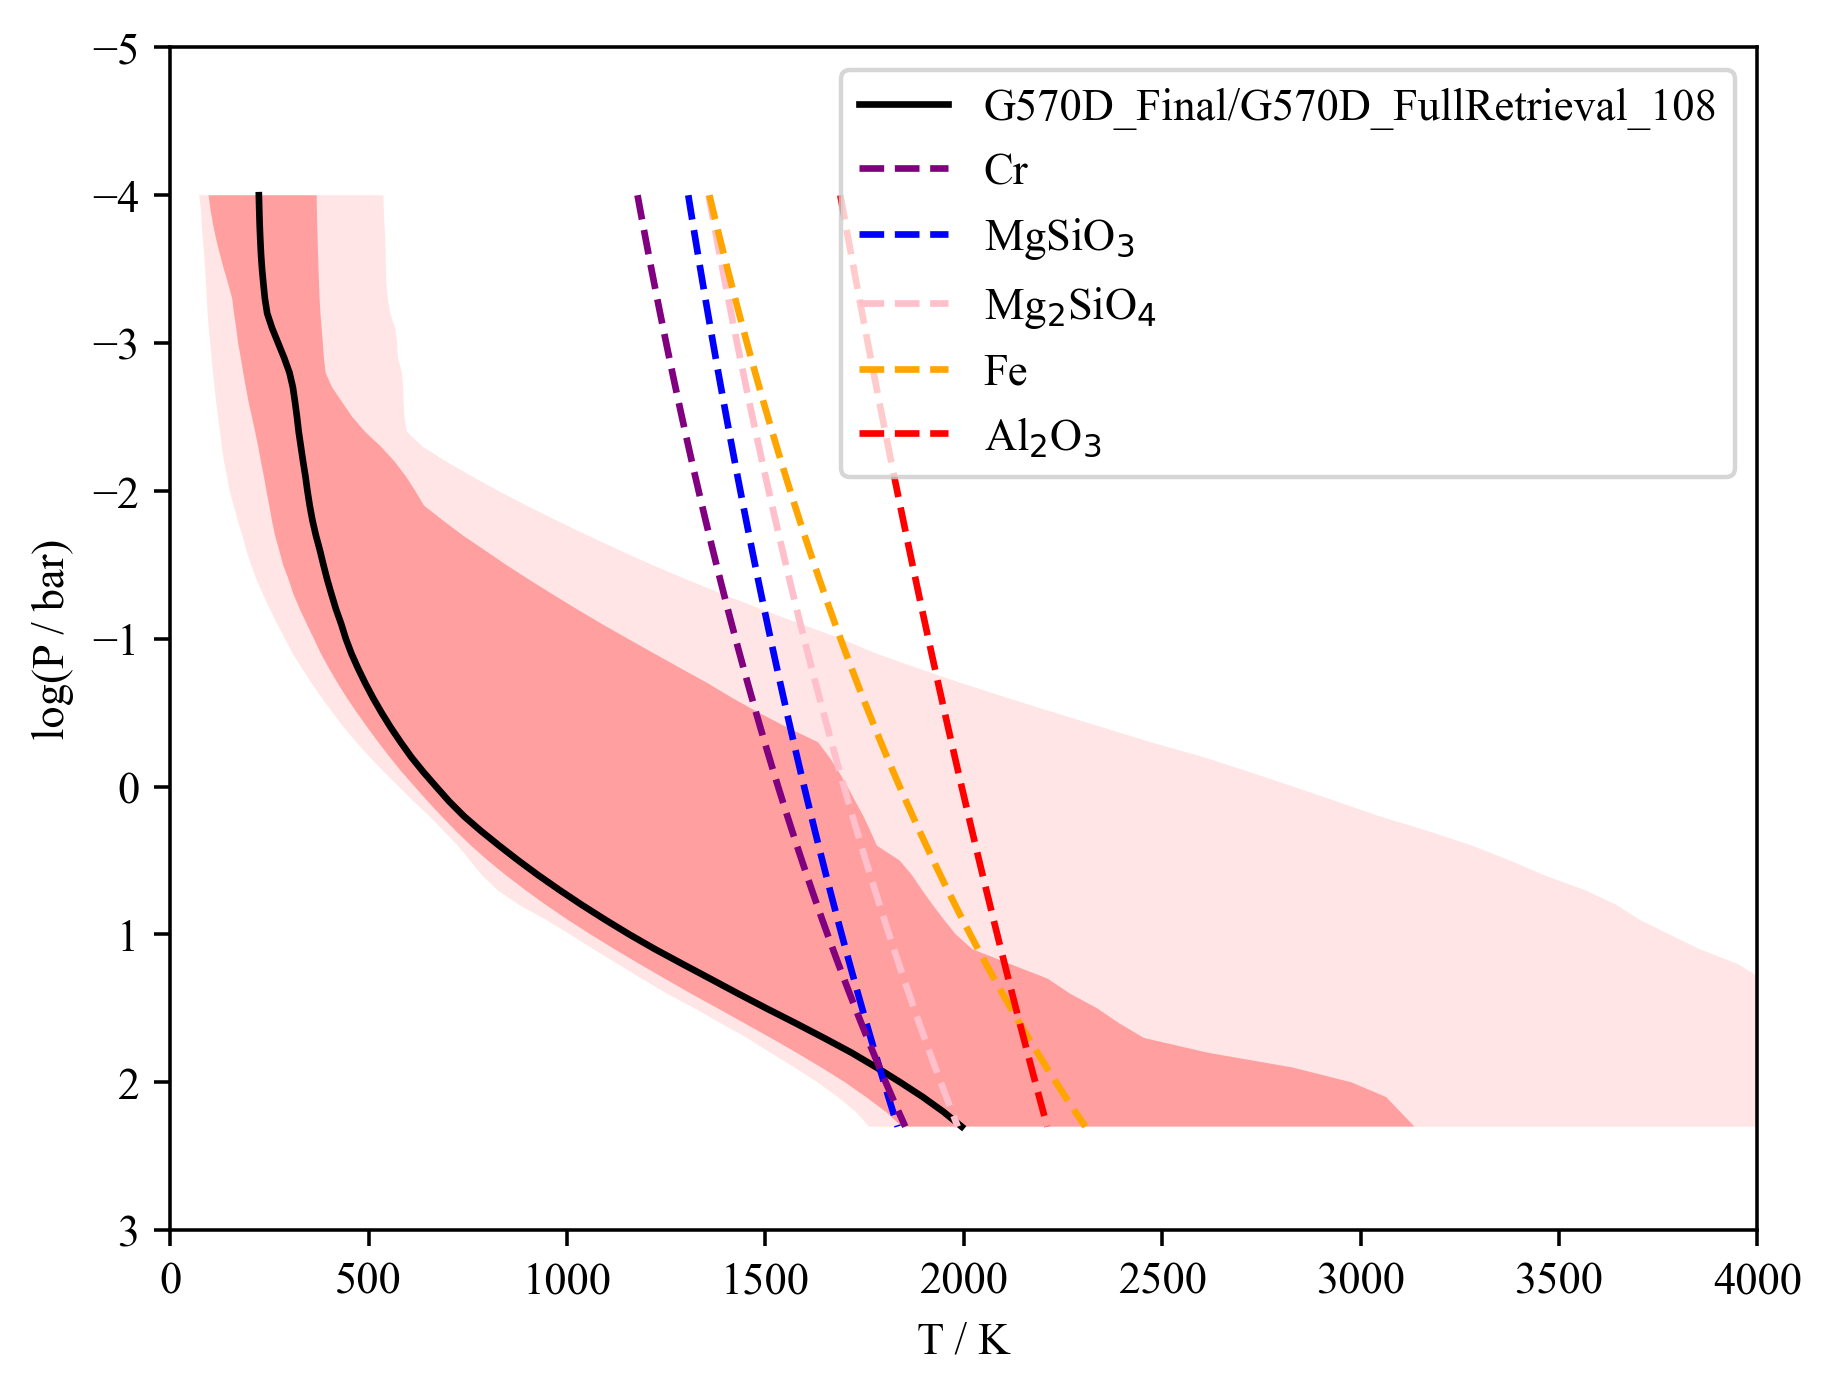

In [9]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0., 4000.,3.0,-5.0])

logP = np.log10(press)

d1, = plt.plot(Tlays[:,2],logP,'k-',label=runname)
plt.fill_betweenx(logP,Tlays[:,1], Tlays[:,3], facecolor='red', alpha=0.3)
plt.fill_betweenx(logP,Tlays[:,0], Tlays[:,4], facecolor='red', alpha=0.1)




# Here are some condensation curves
enst = 10.0**4/(6.26 - 0.35*logP-0.70*0.0)
fost = 10.0**4/(5.89 - 0.37*logP-0.73*0.0)
iron = 10.0**4/(5.44 - 0.48*logP-0.48*0.0)
cr =  10.0**4/(6.528 - 0.491*logP-0.491*0.0)
al2o3 = 10.0**4 / (5.0139 - 0.21794*(logP) + 2.2636E-03*(logP)**2.0 - 0.580*0.0)
c1, = plt.plot(enst,logP,'--',color='blue',linewidth=1.5, label='MgSiO$_3$')
c2, = plt.plot(fost,logP,'--',color='pink',linewidth=1.5,label='Mg$_2$SiO$_4$')
c3, = plt.plot(iron,logP,'--',color='orange',linewidth=1.5, label='Fe')
c4, = plt.plot(cr,logP,'--',color='purple',linewidth=1.5, label='Cr')
c5, = plt.plot(al2o3,logP,'--',color='red',linewidth=1.5, label='Al$_2$O$_3$')

plt.legend(handles=[d1,c4,c1,c2,c3,c5])
plt.ylabel(r'log(P / bar)')
plt.xlabel('T / K')

#asp = 10 / 3.5

#plt.axes().set_aspect(asp)
#plt.savefig(runname+"_profile.png",format='png', dpi=320)

In [10]:
# Save the median profile
np.savetxt(runname+'_profile.dat', np.c_[logP, Tlays[:,2]])

# Next we want to plot the gas abundances in a corner plot.

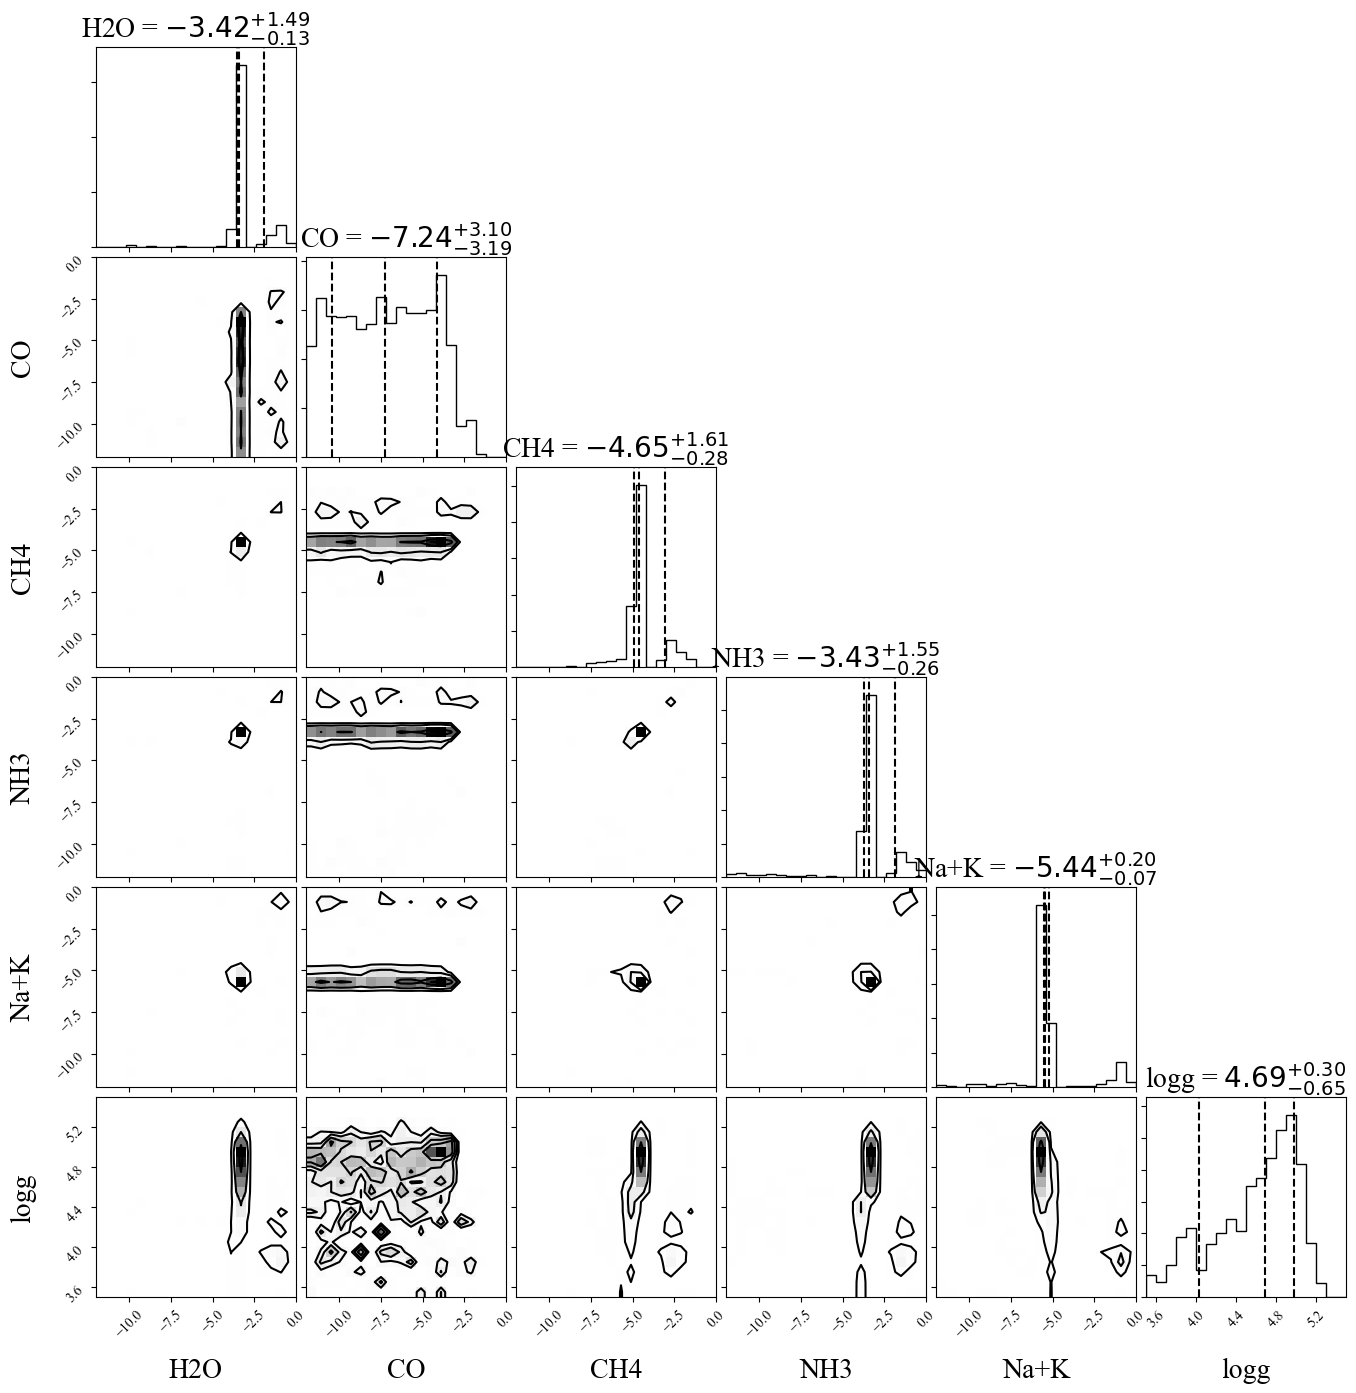

In [11]:
# You'll need to edit this cell to make it work for the gases you've used
# e.g. change the cut you take out of the samples array to get gases and gravity
gassamples = samples[:,0:6]
# set up boundaries for histograms
rh2o = (-12.0,.0)
rco = (-12.0,0.)
#rco2 = (-12.0, 0.)
rch4 = (-12,0.)
rnh3 = (-12,0.)
#rvo= (-12,0.)
#rtio = (-12,-0)
#rcah = (-12,-0)
#rcrh = (-12,0)
#rfeh = (-12.0,-0.0)
rnak = (-12.,0)
rlogg = (3.5,5.5)
# now make an array of the bounds to give to corner plot
bnds = [rh2o,rco,rch4,rnh3,rnak,rlogg]
fig = corner.corner(gassamples,scale_hist=False, range = bnds,plot_datapoints =False,labels=["H2O","CO","CH4","NH3","Na+K","logg"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 20},label_kwargs={"fontsize": 20})

In [12]:
# This saves out the gas mixing ratios
gasVMR = np.ones([gasnum.size-1,3])
for i in range (0,gasnum.size-1):
    gasVMR[i,:] = np.percentile(samples[:,i], [16, 50, 84])
    
np.savetxt(runname+'_VMRs.dat', np.c_[gasVMR[:,0],gasVMR[:,1],gasVMR[:,2]])


# Plotting the model spectra
To plot the model spectra we need to rerun the model, and rerun it for a bunch of random draws from the posterior. This will allow us to plot either a spaghetti plot, or a median + interval spectrum

In [13]:
# no need to get diagnostics along with the spectrum
gnostics = 0
# Now run the model again to get your model spectrum and process to make it look like the data
shiftspec, photspec, tauspec,cfunc = testkit.modelspec(theta_max_end,runargs,gnostics)
topspec = brewtools.proc_spec(shiftspec,theta_max_end,fwhm,chemeq,gasnum,obspec) 


In [14]:
# Now grab 500 random draws from the posterior
pltspec = np.zeros((500,obspec[0,:].size))
samp= np.empty(ndim)
samples = flatendchain
sid = np.zeros(500)
for i in range (0,500):
    sid[i]= np.random.randint(0,high = len(samples))
    samp = samples[int(sid[i]),:]
    shiftspec, photspec, tauspec,cfunc = testkit.modelspec(samp,runargs,gnostics)
    pltspec[i,:] = brewtools.proc_spec(shiftspec,samp,fwhm,chemeq,gasnum,obspec) 
    
# get the intervals for the distribution of model spectra
specdist = np.empty([obspec[0].size,5])
for i in range(0,obspec[0].size):
    junk = pltspec[:,i]
    junk2 = np.percentile(junk, [2.4,16, 50, 84,97.6],axis=0)
    junk3 = np.array(junk2)
    specdist[i,:] = junk3[:]

Text(0.5, 0, 'Wavelength / $\\mu m$')

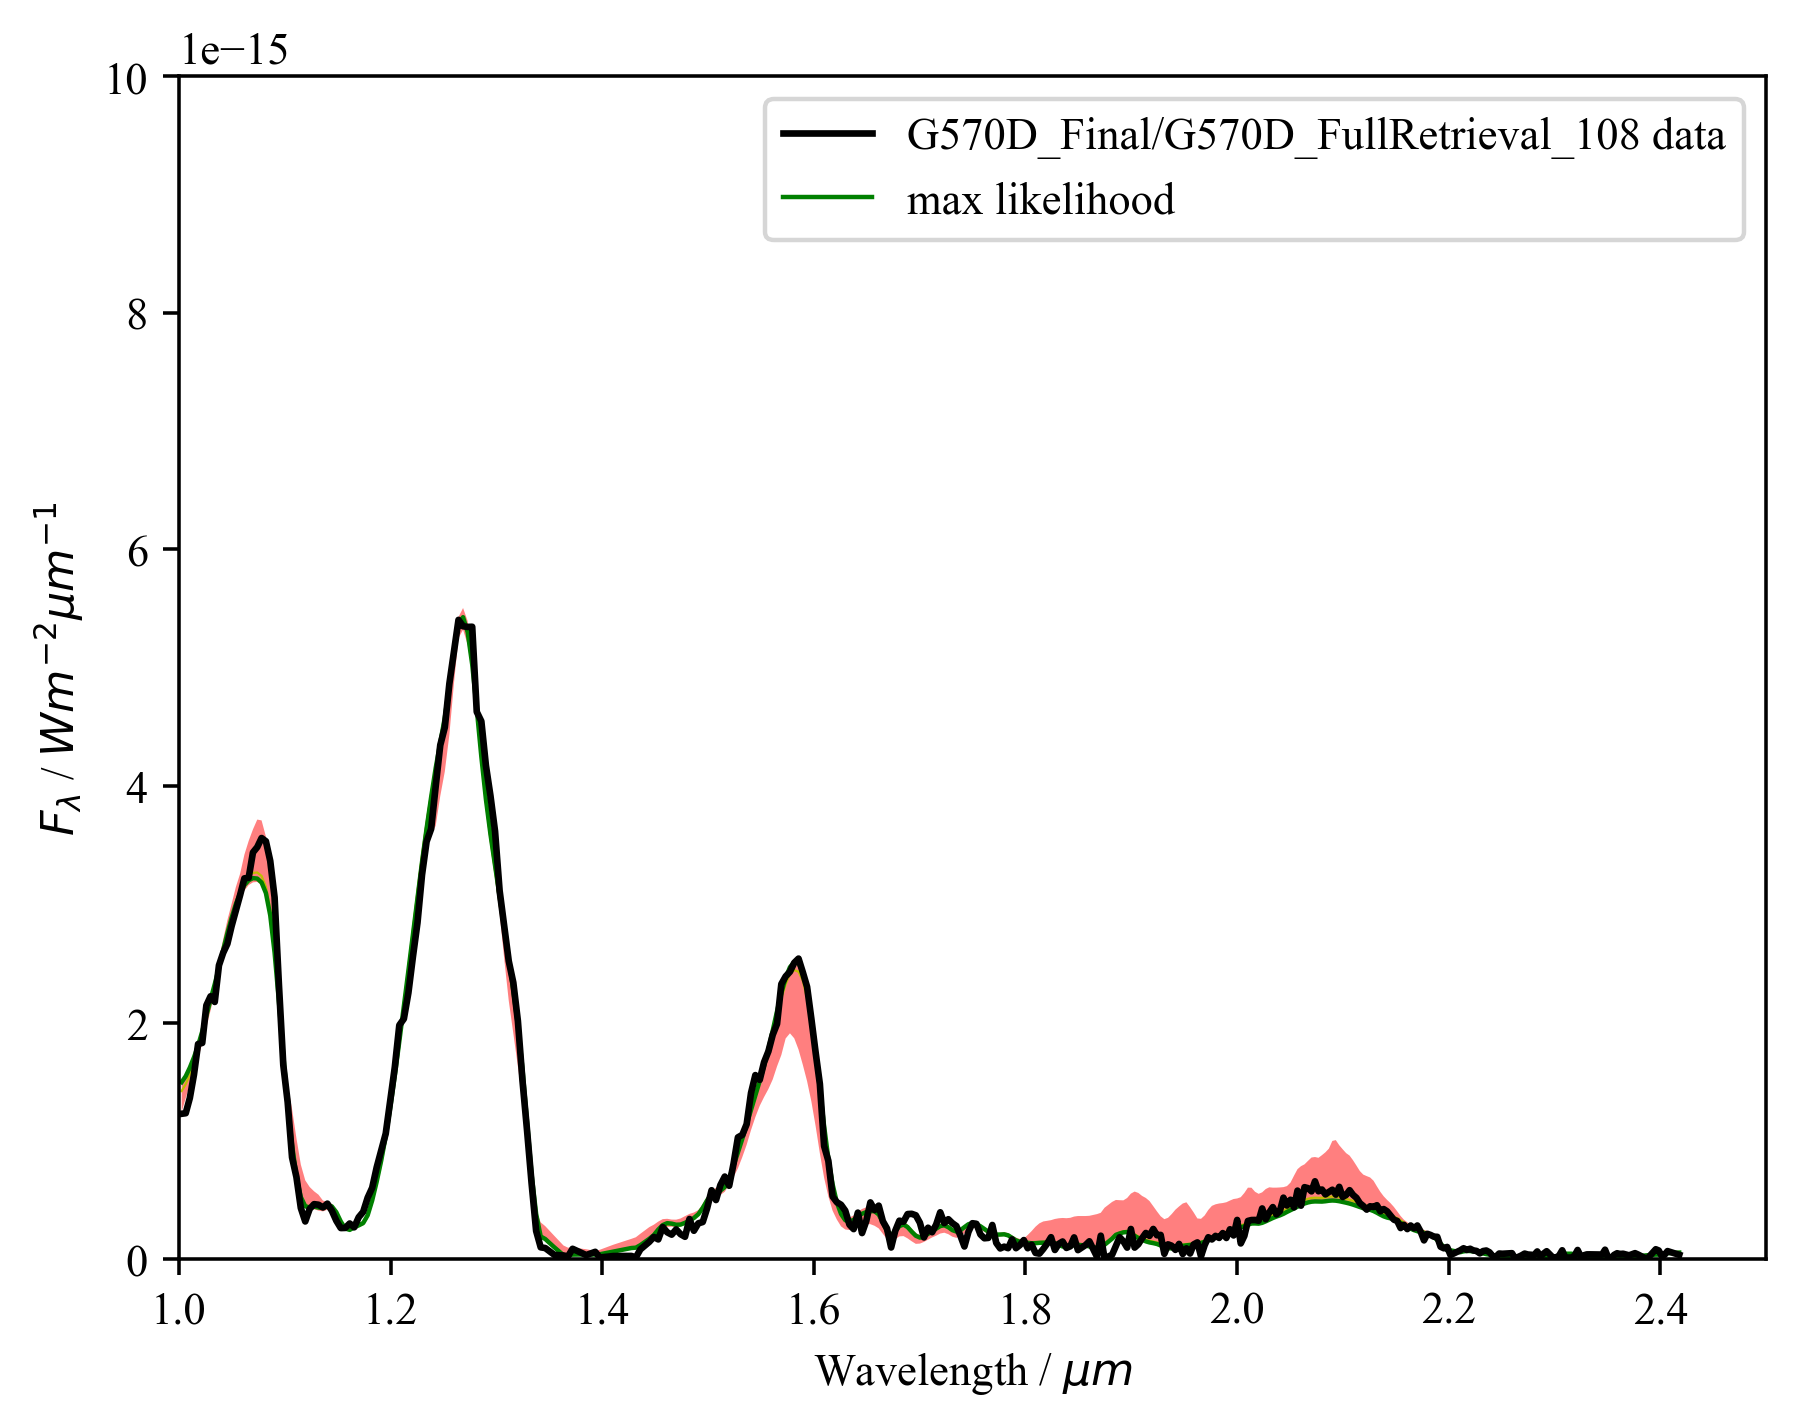

In [16]:
# plot the spectra
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([1.0,2.5,0,1e-14])
# you can swap in the lines below for a log plot
#plt.axis([0.6,15.0, 1.e-17,150e-15])

#ax = fig.add_subplot(1,1,1)

#ax.set_yscale('log')
#ax.set_xscale('log')

# add in below lines for spaghetti plot
#for i in range(0,500):
#    plt.plot(obspec[0],pltspec[i,:],color='r',alpha=0.01)


r1, = plt.plot(obspec[0],specdist[:,2],'y-',linewidth=0.5, label = "median")
#plt.fill_between(obspec[0],specdist[:,0],specdist[:,4],facecolor='red',alpha=0.2)
plt.fill_between(obspec[0],specdist[:,1],specdist[:,3],facecolor='red',alpha=0.5)

t1, = plt.plot(obspec[0,:],topspec,'g-',linewidth=1, label = "max likelihood")
d1, = plt.plot(obspec[0,:],obspec[1,:],'k-',label = runname+" data")


plt.legend(handles=[d1,t1])


plt.ylabel(r'$ F_{\lambda}$ / $Wm^{-2} \mu m^{-1}$')
plt.xlabel('Wavelength / $\mu m$')
#plt.savefig(runname+"_SPAG_SPEC.png",format='png', dpi=320)

In [28]:
# Save you  model spectra
np.savetxt(runname+'_MEDIAN_SPEC.dat', np.c_[obspec[0,:],specdist[:,2],specdist[:,1],specdist[:,3]])
np.savetxt(runname+'_MAX_LIKE_SPEC.dat', np.c_[obspec[0,:],topspec])

# Contribution function
Finally, the contribution function. This is a really useful plot...

In [29]:
# This one plots a contribution function 
# get diagnostics along with the spectrum
gnostics = 1
shiftspec, clphotspec, ophotspec,cfunc = testkit.modelspec(theta_max_end,runargs,gnostics)

nwave = inwavenum.size
cfunc = np.reshape(cfunc,[cfunc.shape[1],cfunc.shape[2]])
fwhm = 0.005
wlen = shiftspec.shape[1]
wint =  shiftspec[0,0] - shiftspec[0,wlen-1]
# convolve with instrumental profile
# start by setting up kernel
# First step is finding the array index length of the FWHM
disp = wint / wlen
gwidth = int((((fwhm / disp) // 2) * 2) +1)
# needs to be odd
# now get the kernel and convolve
gauss = Gaussian1DKernel(gwidth)

for ilayer in range (0,press.size):
    cfunc[:,ilayer] = convolve(cfunc[:,ilayer],gauss,boundary='extend')

tau1_cl_Press = convolve(clphotspec[0],gauss,boundary='extend')[::-1]
tau1_oth_Press = convolve(ophotspec[0],gauss,boundary='extend')[::-1]
    
wavenew = shiftspec[0,::-1]
press = press.reshape(64,)
normfunc = np.zeros_like(cfunc)
for iwave in range(0,nwave):
    totcont = np.sum(cfunc[iwave,:])
    normfunc[iwave,:] = cfunc[iwave,:] / totcont

   

/var/folders/m2/1g4yxt715m54blcw4245j4ch0000gn/T/ipykernel_68029/3921918833.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/Users/carolina/anaconda3/envs/retrievals/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


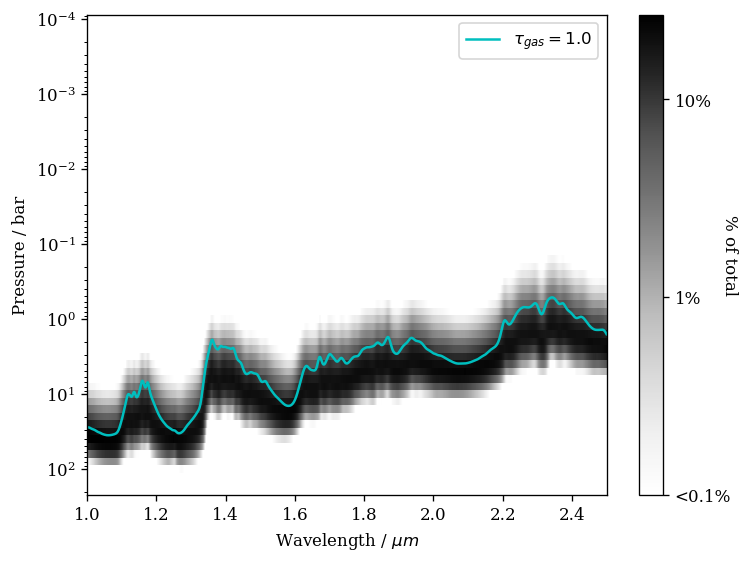

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

plt.rc('font', family='serif')
# plt.rc('text', usetex=False)

fig, ax = plt.subplots(dpi=120)


ax.set_yscale('log')
# ax.set_xscale('log')

# # Set major and minor ticks for the x-axis
# major_ticks = np.arange(1.0, 15.0, 1.0)
# minor_ticks = np.arange(1.0, 15.0, 0.5)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)

pcol = ax.pcolormesh(wavenew, press, (normfunc[::-1, :].transpose()), cmap='Greys',
                     norm=colors.SymLogNorm(linthresh=0.001, linscale=0.00001, vmin=0., vmax=np.amax(normfunc)))

t1, = ax.plot(wavenew, tau1_cl_Press, 'm-', label=r'$\tau_{cloud} = 1.0$')
t2, = ax.plot(wavenew, tau1_oth_Press, 'c-', label=r'$\tau_{gas} = 1.0$')

ax.legend(handles=[t2])

cbar = fig.colorbar(pcol, ax=ax, orientation='vertical', ticks=[1e-3, 1e-2, 0.1])
cbar.ax.set_yticklabels(['<0.1%', '1%', '10%'])
cbar.set_label('% of total', rotation=270)

plt.xlim(1, 2.5)

# ax.set_xticklabels()

ax.invert_yaxis()
ax.set_ylabel('Pressure / bar')
ax.set_xlabel('Wavelength / $\mu m$')

fig.tight_layout()

plt.show()


/var/folders/m2/1g4yxt715m54blcw4245j4ch0000gn/T/ipykernel_68029/1696618999.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/Users/carolina/anaconda3/envs/retrievals/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


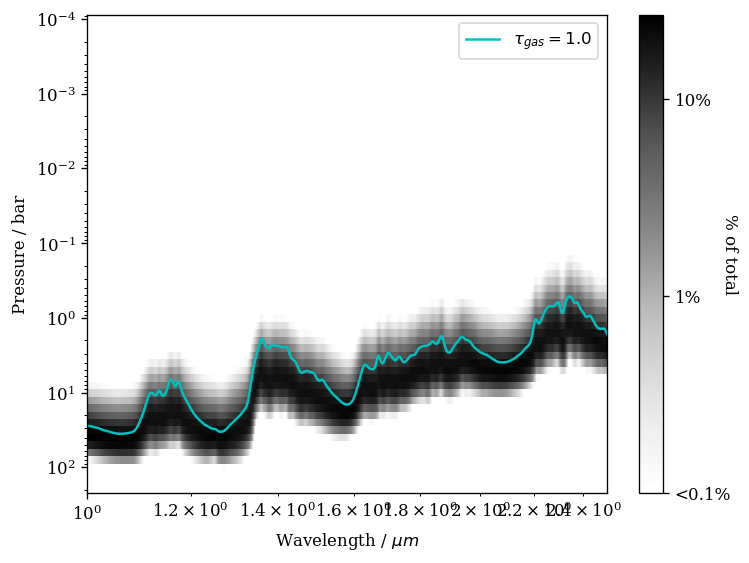

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

plt.rc('font', family='serif')
plt.rc('text', usetex=False)

fig, ax = plt.subplots(dpi=120)


ax.set_yscale('log')
ax.set_xscale('log')

# Set major and minor ticks for the x-axis
major_ticks = np.arange(1.0, 15.0, 1.0)
minor_ticks = np.arange(1.0, 15.0, 0.5)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)

pcol = ax.pcolormesh(wavenew, press, (normfunc[::-1, :].transpose()), cmap='Greys',
                     norm=colors.SymLogNorm(linthresh=0.001, linscale=0.00001, vmin=0., vmax=np.amax(normfunc)))

t1, = ax.plot(wavenew, tau1_cl_Press, 'm-', label=r'$\tau_{cloud} = 1.0$')
t2, = ax.plot(wavenew, tau1_oth_Press, 'c-', label=r'$\tau_{gas} = 1.0$')

ax.legend(handles=[t2])

cbar = fig.colorbar(pcol, ax=ax, orientation='vertical', ticks=[1e-3, 1e-2, 0.1])
cbar.ax.set_yticklabels(['<0.1%', '1%', '10%'])
cbar.set_label('% of total', rotation=270)

plt.xlim(1, 2.5)

ax.invert_yaxis()
ax.set_ylabel('Pressure / bar')
ax.set_xlabel('Wavelength / $\mu m$')

fig.tight_layout()

plt.show()


IndexError: index 5 is out of bounds for axis 0 with size 5

<Figure size 2048x1536 with 0 Axes>

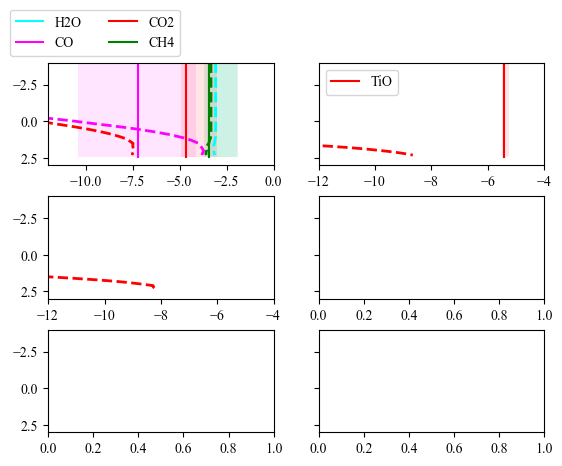

In [32]:
# this plots the gas fractions against a solar metallicity chemical equilibrium prediction
# IT WILL NEED HACKING FOR YOUR CASE. 
intab = np.loadtxt("2015_06_1060grid_feh_00_co_10.txt",skiprows=1)
test = np.array(intab)
test2 = test.reshape(60,18,36)
Pgrid = test2[20:21,:,1]
Pgrid = Pgrid.reshape(18)
Tgrid =  test2[:,10:11,0].reshape(60)
abunds= test2[:,:,2:]
logP, profT = np.loadtxt(runname+"_profile.dat",unpack=True)
nlayers = logP.size
npress = 18
ntemp = 60
ngas = 34
ab_myP = np.empty([ntemp,nlayers,ngas])
for gas in range (0,ngas):
    for i in range (0,ntemp):
            pfit = interp1d(Pgrid,np.log10(abunds[i,:,gas]))
            ab_myP[i,:,gas] = pfit(logP)

            
# Now get the abundances for this profile....
ab = np.empty([nlayers,ngas])
for gas in range(0,ngas):
    for i in range(0,nlayers):
        tfit = InterpolatedUnivariateSpline(Tgrid,ab_myP[:,i,gas],k=1)
        ab[i,gas] = tfit(profT[i])
vmr = gasVMR
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
xl = 1.4
yl= 3.8
lsize = 10
# row and column sharing
fig, ((ax1, ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, sharex=False, sharey=True)
#plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=3.0)
plt.subplots_adjust(hspace=0.3)


ax1.axis([-12.0,0.,3.0,-4.0])
ax1.plot(ab[:,9],logP,'--',color='cyan',linewidth=2)
c1, = ax1.plot([vmr[0,1],vmr[0,1]],[2.4,-4.0],'-',color='cyan',label='H2O')
ax1.fill_betweenx([2.4,-4.0],[vmr[0,0],vmr[0,0]],[vmr[0,2],vmr[0,2]], facecolor='cyan', alpha=0.1,linewidth=0)

ax1.plot(ab[:,11],logP,'--',color='magenta',linewidth=2)
c2, = ax1.plot([vmr[1,1],vmr[1,1]],[2.4,-4.0],'-',color='magenta',label='CO')
ax1.fill_betweenx([2.4,-4.0],[vmr[1,0],vmr[1,0]],[vmr[1,2],vmr[1,2]], facecolor='magenta', alpha=0.1,linewidth=0)

ax1.plot(ab[:,25],logP,'--',color='red',linewidth=2)
c3, = ax1.plot([vmr[2,1],vmr[2,1]],[2.4,-4.0],'-',color='red',label='CO2')
ax1.fill_betweenx([2.4,-4.0],[vmr[2,0],vmr[2,0]],[vmr[2,2],vmr[2,2]], facecolor='red', alpha=0.1,linewidth=0)

ax1.plot(ab[:,10],logP,'--',color='green',linewidth=2)
c4, = ax1.plot([vmr[3,1],vmr[3,1]],[2.4,-4.0],'-',color='green',label='CH4')
ax1.fill_betweenx([2.4,-4.0],[vmr[3,0],vmr[3,0]],[vmr[3,2],vmr[3,2]], facecolor='green', alpha=0.1,linewidth=0)
lgd = ax1.legend(handles=[c1,c2,c3,c4],prop={'size':lsize},loc='best', bbox_to_anchor=(-0.2, 1.0),
          ncol=2)

      
ax2.axis([-12.0,-4.0,3.0,-4.0])      
ax2.plot(ab[:,16],logP,'--',color='red',linewidth=2)
c3, = ax2.plot([vmr[4,1],vmr[4,1]],[2.4,-4.0],'-',color='red',label='TiO')
ax2.fill_betweenx([2.4,-4.0],[vmr[4,0],vmr[4,0]],[vmr[4,2],vmr[4,2]], facecolor='red', alpha=0.1,linewidth=0)
ax2.legend(handles=[c3],prop={'size':lsize})

ax3.axis([-12.0,-4.0,3.0,-4.0])      
ax3.plot(ab[:,17],logP,'--',color='red',linewidth=2)
c4, = ax3.plot([vmr[5,1],vmr[5,1]],[2.4,-4.0],'-',color='red',label='VO')
ax3.fill_betweenx([2.4,-4.0],[vmr[5,0],vmr[5,0]],[vmr[5,2],vmr[5,2]], facecolor='red', alpha=0.1,linewidth=0)
ax3.legend(handles=[c4],prop={'size':lsize})


ax4.axis([-12.0,-4.0,3.0,-4.0])      
ax4.plot(ab[:,20],logP,'--',color='red',linewidth=2)
c5, = ax4.plot([vmr[6,1],vmr[6,1]],[2.4,-4.0],'-',color='red',label='CrH')
ax4.fill_betweenx([2.4,-4.0],[vmr[6,0],vmr[6,0]],[vmr[6,2],vmr[6,2]], facecolor='red', alpha=0.1,linewidth=0)
ax4.legend(handles=[c5],prop={'size':lsize})

ax5.axis([-12.0,-4.0,3.0,-4.0])      
ax5.plot(ab[:,19],logP,'--',color='red',linewidth=2)
c6, = ax5.plot([vmr[7,1],vmr[7,1]],[2.4,-4.0],'-',color='red',label='FeH')
ax5.fill_betweenx([2.4,-4.0],[vmr[7,0],vmr[7,0]],[vmr[7,2],vmr[7,2]], facecolor='red', alpha=0.1,linewidth=0)
ax5.legend(handles=[c6],prop={'size':lsize})

alks = np.log10((10.**ab[:,22]) + (10.**ab[:,21]))

ax6.axis([-10.,-4.0,3.0,-4.0])      
ax6.plot(alks,logP,'--',color='red',linewidth=2)
c7, = ax6.plot([vmr[8,1],vmr[8,1]],[2.4,-4.0],'-',color='red',label='Na+K')
ax6.fill_betweenx([2.4,-4.0],[vmr[8,0],vmr[8,0]],[vmr[8,2],vmr[8,2]], facecolor='red', alpha=0.1,linewidth=0)
ax6.legend(handles=[c7],prop={'size':lsize})

txt = fig.text(0.5, 0.04, '$\log f_{gas}$', ha='center')
fig.text(0.04, 0.5, '$\log P / bars$', va='center', rotation='vertical')


#plt.savefig(runname+'_abundances.png',format='png', dpi=320, bbox_extra_artists=(lgd,txt,),bbox_inches='tight')